In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings

In [2]:
# Set the system parameters
a = 1
uD = 1
t0 = 3.1
t1 = 5
t2 = -0.21
t3 = 0.29
t4 = 0.141
Nl = 1

1

The above parameters are the ones to be used when computing the energies of the Hamiltonian. 
- $a$ is the lattice constant.
- $u_D$ is the potential difference per layer
- $t_0$ is the graphene hopping
- $t_1$ is the vertical interlayer hopping
- $t_2, t_3, t_4$ are higher order (next-nearest, next-next-nearest, ...) hopping
- $N_l$ is the number of layers

<font size="12">RMG Hamiltonian</font>

In this section we will be constructing the RMG Hamiltonian, which is given by the following form:

\begin{equation*}
h_{RG}^{(N_l)} (k) = 
    \begin{bmatrix}
    h_1^{(0)} & h^{(1)} & h^{(2)} \\
    {h^{(1)}}^\dagger & h_2^{(0)} & h^{(1)} & h^{(2)} \\
    {h^{(2)}}^\dagger & {h^{(1)}}^\dagger & h_3^{(0)} & \ddots & \ddots \\
    & {h^{(2)}}^\dagger & \ddots & \ddots & h^{(1)} & h^{(2)} \\
    & & \ddots & {h^{(1)}}^\dagger & h_{N_l - 1}^{(0)} & h^{(1)} \\
    & & & {h^{(2)}}^\dagger & {h^{(1)}}^\dagger & h_{N_l}^{(0)}
    \end{bmatrix}
\end{equation*}
where 

\begin{equation*}
h_l^{(0)} (k) = 
    \begin{bmatrix}
    u_{Al} & -t_0 f_k \\
    -t_0 \bar{f_k} & u_{B l}
    \end{bmatrix}
\end{equation*}
and 

\begin{equation*}
h^{(1)} (k) = 
    \begin{bmatrix}
    t_4 f_k & t_3 \bar{f_k} \\
    t_1 & t_4 f_k
    \end{bmatrix}
\end{equation*}
and

\begin{equation*}
h^{(2)} (k) = 
    \begin{bmatrix}
    0 & \frac{t_2}{2} \\
    0 & 0
    \end{bmatrix}
\end{equation*}
and

\begin{equation*}
f_k = \sum_{i = 0}^2 e^{i \vec{k} \cdot \vec{\delta}_i}
\end{equation*}

- The nearest-neighbor vectors $\vec{\delta}_n$ take the form 
$\vec{\delta}_n = R_{n 2 \pi / 3} (0, \frac{1}{\sqrt{3}} a)^T$ where $R_\theta$ is the counterclockwise rotation matrix by angle $\theta$.
- $u_{\sigma, l} = u_D (l + 1 - \frac{N_l - 1}{2})$

In [3]:
# 2D CCW rotation of v by theta
function rot(theta, v)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R * v
end

rot (generic function with 1 method)

In [4]:
function f(k, a)
    kx = k[1]
    ky = k[2]
    return exp(1im * ky * a / sqrt(3)) * (1 + 2 * exp(-1im * 3 * ky * a / (2 * sqrt(3))) * cos(kx * a / 2))
end

f (generic function with 1 method)

The above functions simply serve to calculate the in-layer graphene hopping contributions.

In [5]:
function uAB(uD, Nl, l)
    return uD * (l + 1 - (1/2) * (Nl - 1))
end

uAB (generic function with 1 method)

Above is the on-site potential as a function of layer-index ($l$). 

In [6]:
function h0(uD, Nl, l, t0, a, k)
    uA = uAB(uD, Nl, l)
    uB = uAB(uD, Nl, l)
    h0 = zeros(ComplexF64, 2, 2)
    h0[1, 1] = uA
    h0[2, 2] = uB
    h0[1, 2] = -t0 * f(k, a)
    h0[2, 1] = -t0 * conj(f(k, a))
    return h0
end

h0 (generic function with 1 method)

The above function calculates the matrix $h_0$ in sublattice space.

In [7]:
function h1(t1, t3, t4, a, k)
    h1 = zeros(ComplexF64, 2, 2)
    h1[1, 1] = t4 * f(k, a)
    h1[1, 2] = t3 * conj(f(k, a))
    h1[2, 1] = t1
    h1[2, 2] = t4 * f(k, a)
    return h1
end

h1 (generic function with 1 method)

The above function calculates the matrix $h_1$ in sublattice space.

In [8]:
function h2(t2)
    h2 = zeros(ComplexF64, 2, 2)
    h2[1,2] = t2/2
    return h2
end

h2 (generic function with 1 method)

The above function calculates the matrix $h_2$ in sublattice space.

In [9]:
function hRG(a, uD, t0, t1, t2, t3, t4, Nl, k)
    # calculate the portion of hRG that has h0 on the diagonal
    ham0 = zeros(2 * Nl, 2 * Nl)
    for l in 1:Nl
        temp = zeros(Nl, Nl)
        temp[l, l] = 1
        ham0 += kron(h0(uD, Nl, l, t0, a, k), temp)
    end
    # calculate the portion of hRG that has h1 1 above and below the diagonal
    utri1 = zeros(Nl, Nl)
    for i in 2:Nl
        utri1[i - 1, i] = 1
    end
    ham1 = kron(h1(t1, t3, t4, a, k), utri1) + adjoint(kron(h1(t1, t3, t4, a, k), utri1))
    # calculate the portion of hRG that h2 2 above and below the diagonal
    utri2 = zeros(Nl, Nl)
    for i in 3:Nl
        utri2[i - 2, i] = 1
    end
    ham2 = kron(h2(t2), utri2) + adjoint(kron(h2(t2), utri2))
    # get all the contributions of hRG from the various matrices in sublattice space
    return ham0 + ham1 + ham2
end

hRG (generic function with 1 method)

To test out the hRG Hamiltonian-constructing function, we plot the band-structure of monolayer graphene.

<font size="12">Monolayer Graphene Band Structure</font>

In [10]:
samps = 1000
k_range = range(-2*pi/a, 2*pi/a, samps)

-6.283185307179586:0.012578949563923095:6.283185307179586

In [11]:
# Get the dipersions for fixed ky
K_temp_vals = Array{Float64}(undef, samps, samps, 2 * Nl)
K_temp_points = Array{Float64}(undef, samps, samps, 2)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
        vals = eigvals(ham)
        K_temp_vals[i, j, :] = real(vals)
        K_temp_points[i, j, :] = [kx, ky]
    end
end

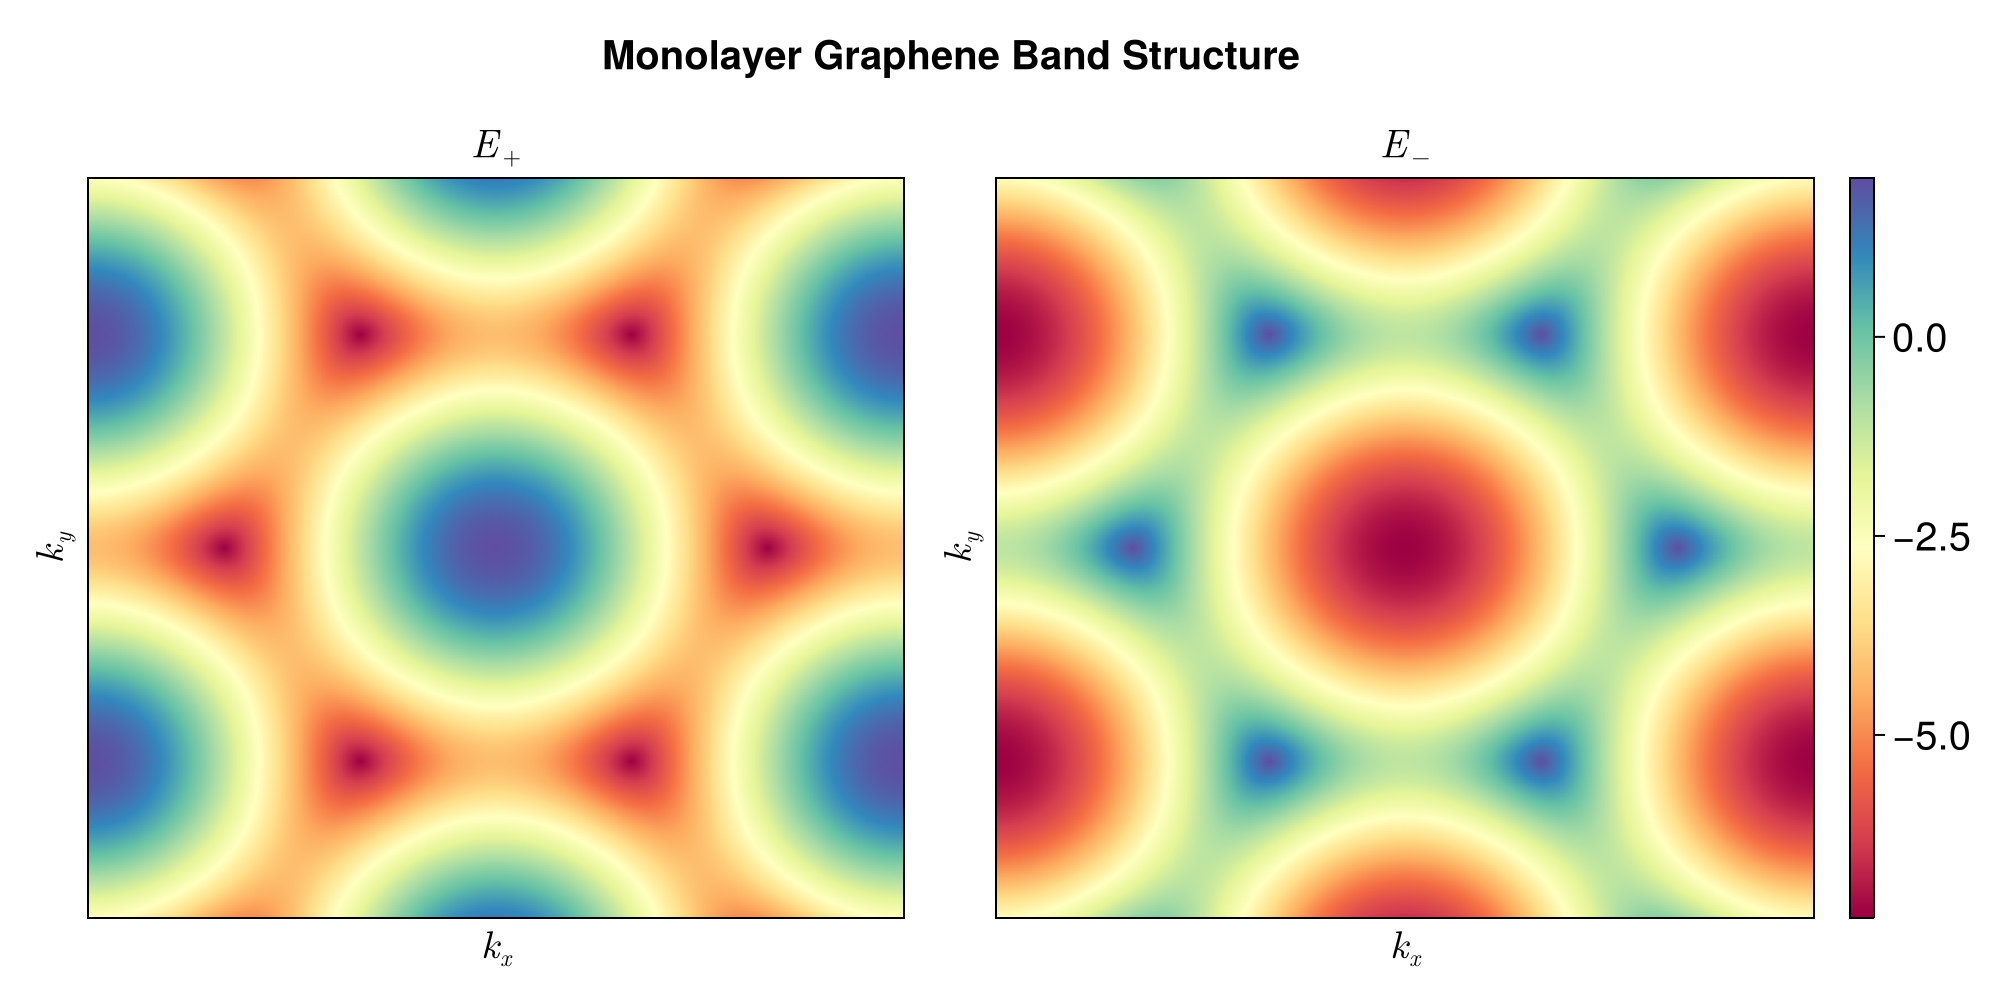

In [12]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)

# create and configure axes
ax_plus = Axis(P[1, 1], title = L"E_+", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_plus, label = false)
ax_minus = Axis(P[1, 2], title = L"E_-", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_minus, label = false)
ax_major = Axis(P[:, :], title = "Monolayer Graphene Band Structure", titlegap = 50)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

#plot dispersions
heatmap!(ax_plus, k_range, k_range, K_temp_vals[:, :, 2], colormap = :Spectral)
heatmap!(ax_minus, k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)
X, ax, tr = heatmap(k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)

#create and configure the colorbar
cb = Colorbar(P[1, 3], tr)
P

Evidently the Hamiltonian creation and diagonalization appears to be working (at least for $N_l = 1$), so we will proceed with the analysis of RMG

<font size="12">RMG Band Structure</font>

In [13]:
# Increase layer number
Nl = 3
# These vectors will be useful for computing energies at high-symmetry (K and K') points
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 2*pi/a * 2/sqrt(3)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 2.0943951023931953
 3.6275987284684357

- $G_1 = \frac{2 \pi}{a} \left(1, - \frac{1}{\sqrt{3}}\right)$ and $G_2 = \frac{2 \pi}{a} \left(0, \frac{2}{\sqrt{3}}\right)$ are reciprocal lattice basis vectors
- $K = \frac{2}{3} G_1 + \frac{1}{3} G_2$ and $K^\prime = \frac{1}{3} G_1 + \frac{2}{3} G_2$ are Dirac points

In [14]:
# Want to get dispersions around K point
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    K_eigenvals[i, :] = real(vals)
end
# Want to get dispersions around K' point
Kp_eigenvals = Array{Float64}(undef, samps, 2 * Nl)

for i in 1:samps
    kx = k_range[i]
    ky = Kp[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    Kp_eigenvals[i, :] = real(vals)
end

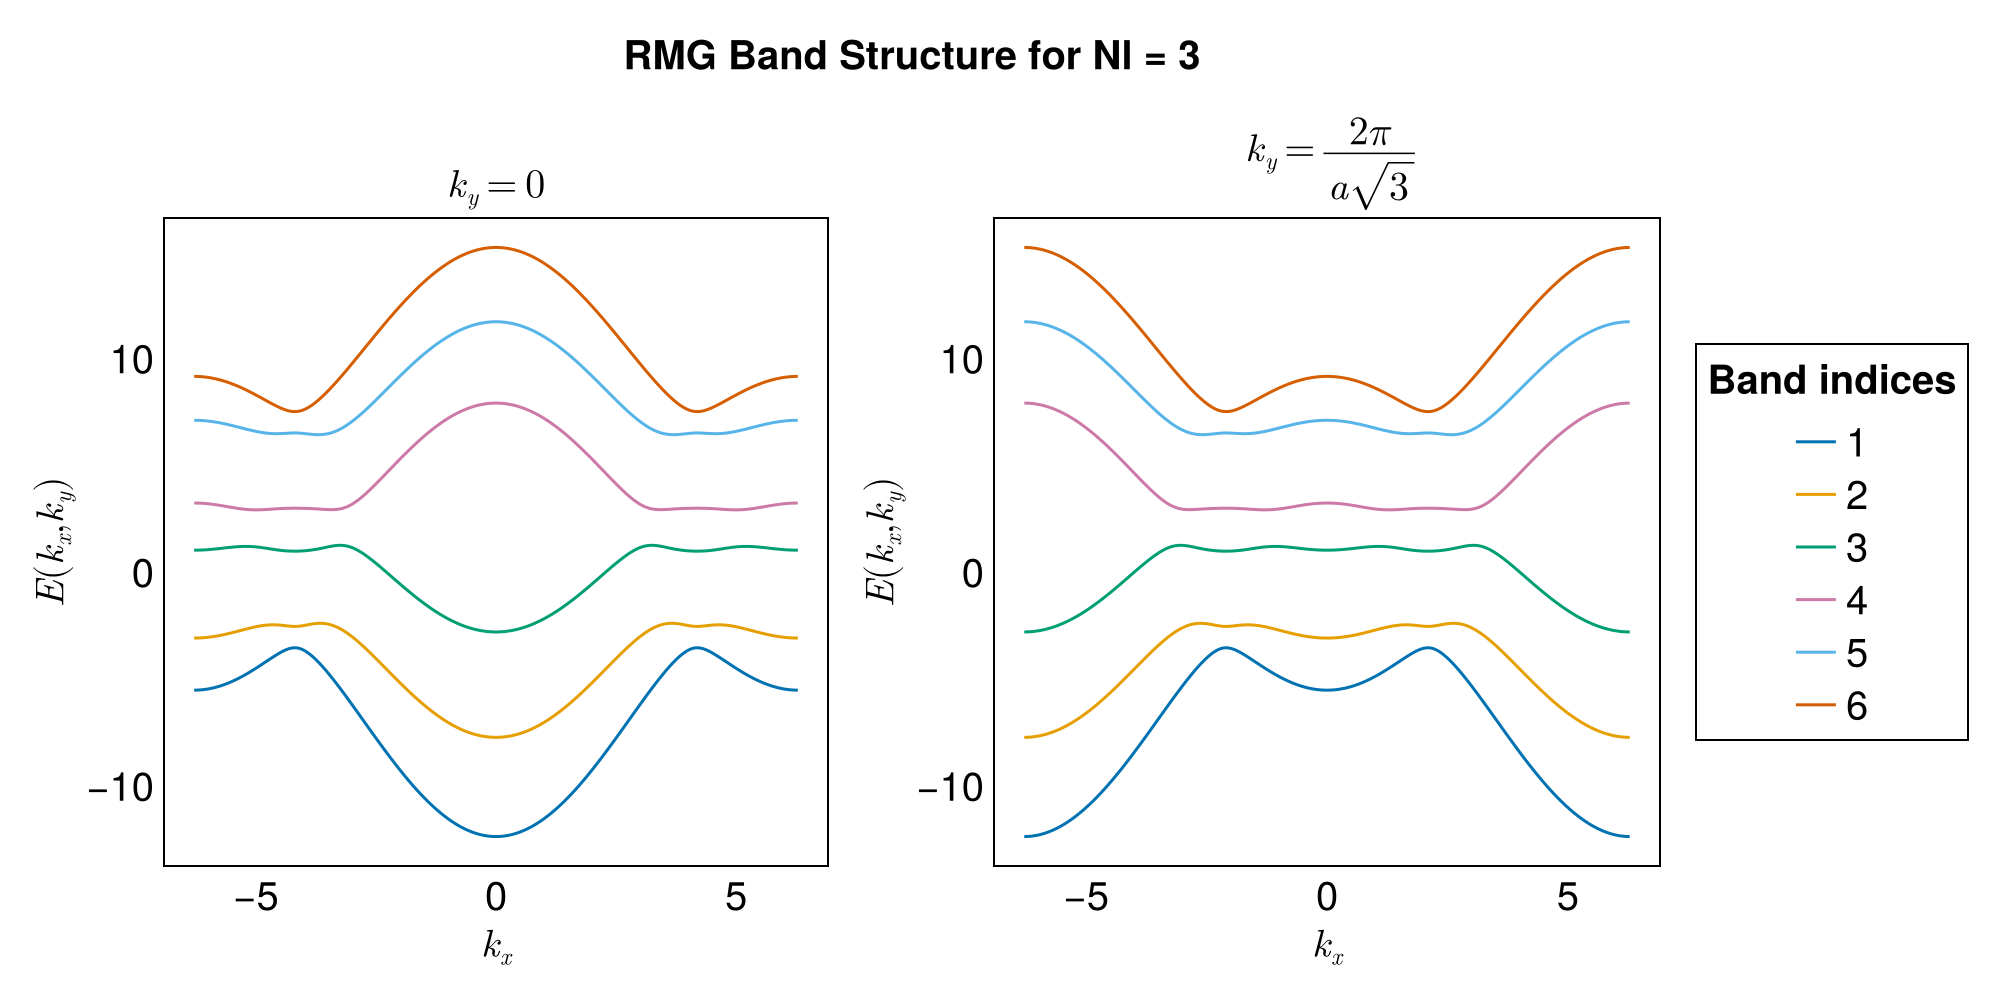

In [15]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax_k = Axis(P[1, 1], title = L"k_y = 0", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_k, label = false, ticklabels = false)
ax_kp = Axis(P[1, 2], title = L"k_y = \frac{2 \pi}{a \sqrt{3}}", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_kp, label = false, ticklabels = false)
ax_major = Axis(P[:, :], title = string("RMG Band Structure for Nl = ", string(Nl)), titlegap = 70)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

# plot bands
for i in 1:2*Nl
    lines!(ax_k, k_range, K_eigenvals[:, i], label = string(i))
    lines!(ax_kp, k_range, Kp_eigenvals[:, i], label = string(i))
end

# create and configure legend
P[1, 3] = Legend(P, ax_k, "Band indices", framevisible = true)
P

<font size="12">RMG Berry Curvature</font>

In [16]:
# pd is point-density
pd = 100
# lims for 1 unit cell
uc_xlim = 4*pi/a
uc_ylim = uc_xlim * sqrt(3) / 2
# dimension of unit cell patchwork (n_cell x n_cell)
n_cell = 5
# dimensions of the enlarged k-space cell
xlim = n_cell * uc_xlim
ylim = n_cell * uc_ylim
uD = 10

10

There are a few important notes to make here. 
- We discretize a single unit cell into a parallelogram of ${pd}^2$ points in k-space.
- To observe interesting features of Berry curvature near Dirac points, we must compute the Berry curvature $> 1$ (${n_{cell}}^2$) unit cells. 
- Then we appropriately set the $x$ and $y$ limits ($xlim, ylim$) to ensure that the resulting patchwork of unit cells is still a parallelogram (this doesn't matter too much).

In [17]:
# This generates a line of points in K-space
function gen_list(xlim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end
# This generates a single unit cell of points in K-space
function gen_grid(xlim, n)
    step = range(0, xlim, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(xlim, n, 0.5*step[i], (sqrt(3)/2)*step[i])
    end
    return grid
end
# Shift a grid over
function shift_grid(grid, n, xshift, yshift)
    new_grid = copy(grid)
    for i in 1:n
        new_grid[:, i, 2] += yshift * ones(size(grid[:, i, 2]))
        new_grid[:, i, 1] += xshift * ones(size(grid[:, i, 1]))
    end
    return new_grid
end

shift_grid (generic function with 1 method)

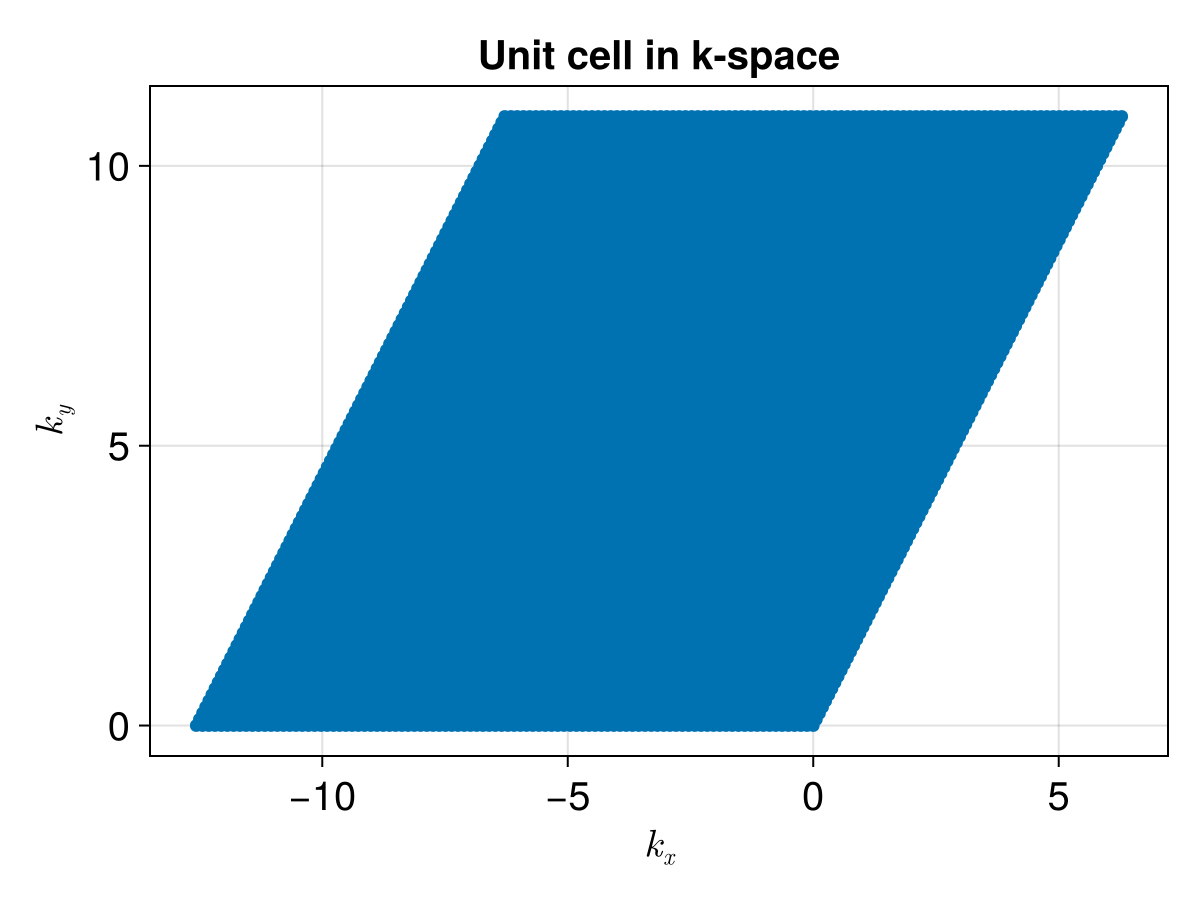

In [18]:
# Sample unit cell in k-space
uc_k_grid = gen_grid(uc_xlim, pd)
# uc_k_grid = shift_grid(uc_k_grid, pd, xlim, ylim)
uc_k_mesh = reshape(uc_k_grid, (pd^2, 2))
P = Figure(fontsize = 20)
ax_major = Axis(P[:, :], title = "Unit cell in k-space", xlabel = L"$k_x$", ylabel = L"$k_y$")
scatter!(ax_major, uc_k_mesh[:, 1], uc_k_mesh[:, 2])
P

This parallelogram is still a valid Brillouin zone because it is formed by connecting the centers of $4$ hexagons in k-space (which forms a Brillouin zone). The reason we use a parallelogram unit cell over a hexagonal unit cell is because there are Dirac points contained within the parallelogram, so it is easier to see unique Berry curvature behavior using this unit cell.

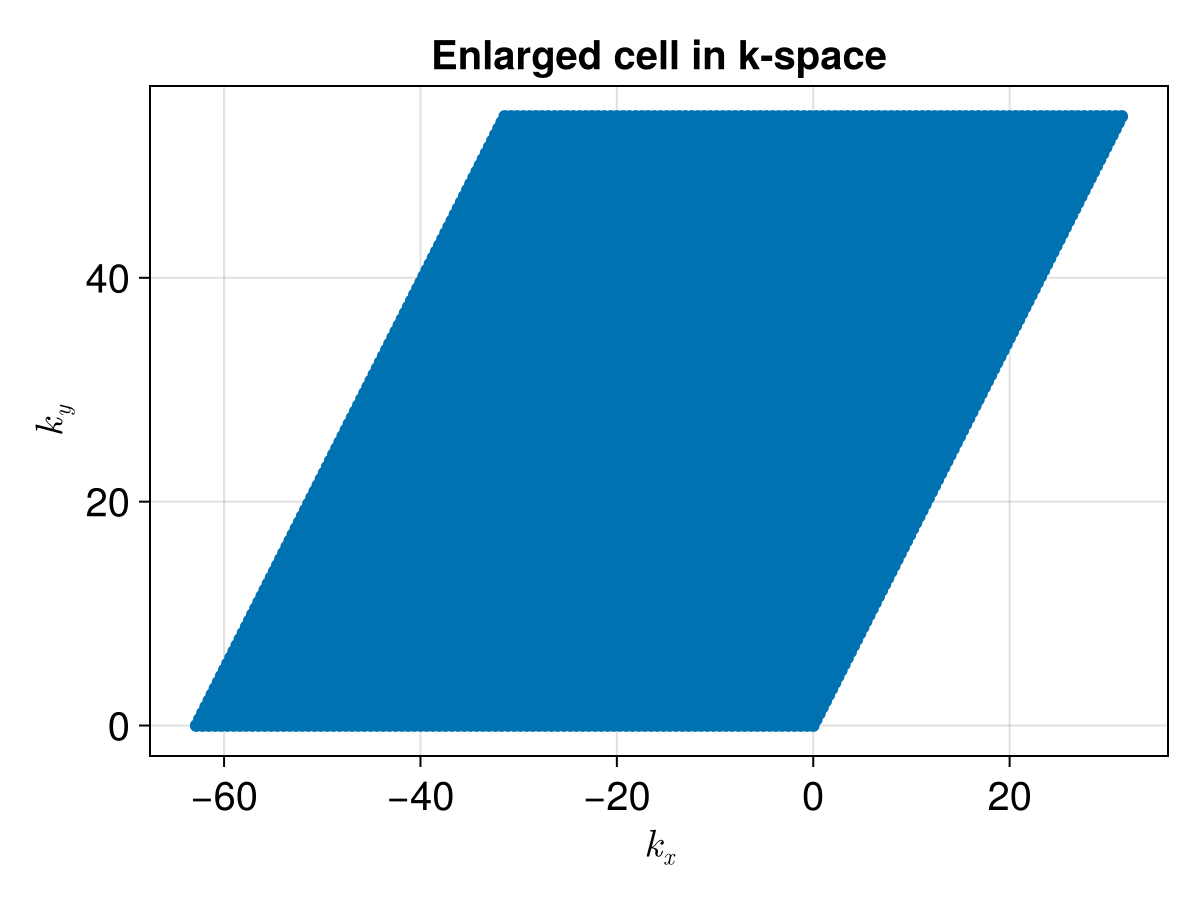

In [19]:
# Enlarged cell in k-space
k_grid = gen_grid(n_cell*uc_xlim, pd)
k_mesh = reshape(k_grid, (pd^2, 2))
P = Figure(fontsize = 20)
ax_major = Axis(P[:, :], title = "Enlarged cell in k-space", xlabel = L"$k_x$", ylabel = L"$k_y$")
scatter!(ax_major, k_mesh[:, 1], k_mesh[:, 2])
P

An important note regarding this discretization of k-space is that increasing $n_{cell}$ does not make the lattice finer. In contrast, it actually makes the lattice coarser since we now spread the same number of points across a larger region. So typically, when we increase $n_{cell}$ we will also have to increase $pd$ to ensure that the quality of the discrete Brillouin zone does not deteriorate too much.

Now we compute the Berry curvature according to the following method. This method provides a gauge-invariant computation of the Berry curvature for a discrete Brillouin zone. 
- Suppose $\psi_k^{l}$ is the wave-function for the $l^{\text{th}}$ band.
- Define $e^{i\theta_{12}}_l = \frac{\langle \psi_{k2}^l | \psi_{k1}^l \rangle}{| \langle \psi_{k2}^l | \psi_{k1}^l \rangle|}$
- Then we can compute the Berry flux through a plaquette with corners represented by points (1, 2, 3, 4) as 
$\Phi_{1234}^l = arg(e^{i\theta_{21}}_l e^{i\theta_{32}}_l e^{i\theta_{43}}_l e^{i\theta_{14}}_l)$
- Here we define the Berry curvature as $B_z^l (k) = A * \Phi_{1234}^l$ where $A$ is the area of the plaquette. In our actual computation we don't account for the area because it's just a proportionality factor.
- Then using this definition of the Berry curvature, we can compute the Chern number of a band as 
$C^l = \frac{1}{2 \pi} \int_{BZ} dk B^l_z (k)$ 
    - Here $\int_{BZ}$ is an integral over the Brillouin zone.

In [20]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec(l, kx, ky, a, uD, t0, t1, t2, t3, t4, Nl)
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vecs = eigvecs(Hermitian(ham))
    return vecs[:, l]
end

eigen_vec (generic function with 1 method)

In [21]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(l, x1, y1, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl)
    ev1 = eigen_vec(l, x1, y1, a, uD, t0, t1, t2, t3, t4, Nl)
    ev2 = eigen_vec(l, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [22]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(l, x1, y1, x2, y2, x3, y3, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl)
    big_theta = theta(l, x2, y2, x1, y1, a, uD, t0, t1, t2, t3, t4, Nl) *
        theta(l, x3, y3, x2, y2, a, uD, t0, t1, t2, t3, t4, Nl) * theta(l, x4, y4, x3, y3, a, uD, t0, t1, t2, t3, t4, Nl) * 
    theta(l, x1, y1, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [23]:
# Berry curvature over all plaquettes
function berry_curvature(l, points, n, a, uD, t0, t1, t2, t3, t4, Nl)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux(l, x1, y1, x2, y2, x3, y3, x4, y4, a, uD, t0, t1, t2, t3, t4, Nl)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 1 method)

In [24]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
for l in 1:2*Nl
    temp_flux, akx, aky = berry_curvature(l, k_grid, pd, a, uD, t0, t1, t2, t3, t4, Nl)
    uc_temp_flux, trash, trash = berry_curvature(l, uc_k_grid, pd, a, uD, t0, t1, t2, t3, t4, Nl)
    uc_flux_list[l, :] = uc_temp_flux
    flux_list[l, :] = temp_flux
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
end
end

  7.746582 seconds (37.78 M allocations: 16.216 GiB, 9.08% gc time, 0.75% compilation time)


In [25]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2*Nl)
for l in 1:2*Nl
    chern_numbers[l] = sum(uc_flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

chern_numbers = [-2.161783260057234e-16, 3.103249532955723e-16, 6.350065770283063e-16, 1.1595772276169071e-15, 8.901135671040259e-16, 9.514055062780624e-16]


6-element Vector{Float64}:
 -2.161783260057234e-16
  3.103249532955723e-16
  6.350065770283063e-16
  1.1595772276169071e-15
  8.901135671040259e-16
  9.514055062780624e-16

In [26]:
# Plot the Berry curvatures for each band over the enlarged cell
function plot_berry(fig, kx_list, ky_list, fluxes)
    for i in 1:2
        for j in 1:Nl
            index = (i - 1) * Nl + j
            t_string = "l = "*string(index)
            ax = Axis(fig[j, i], title = t_string)
            hidedecorations!(ax)
            tricontourf!(ax, kx_list[index, :], ky_list[index, :], fluxes[index, :], colormap = :Spectral)
        end
    end
    X, ax, tr = tricontourf(kx_list[1, :], ky_list[1, :], fluxes[1, :], colormap = :Spectral)
    cb = Colorbar(fig[1:Nl, 3], tr)
    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
end

plot_berry (generic function with 1 method)

 12.714618 seconds (21.44 M allocations: 1.307 GiB, 4.00% gc time, 29.84% compilation time)


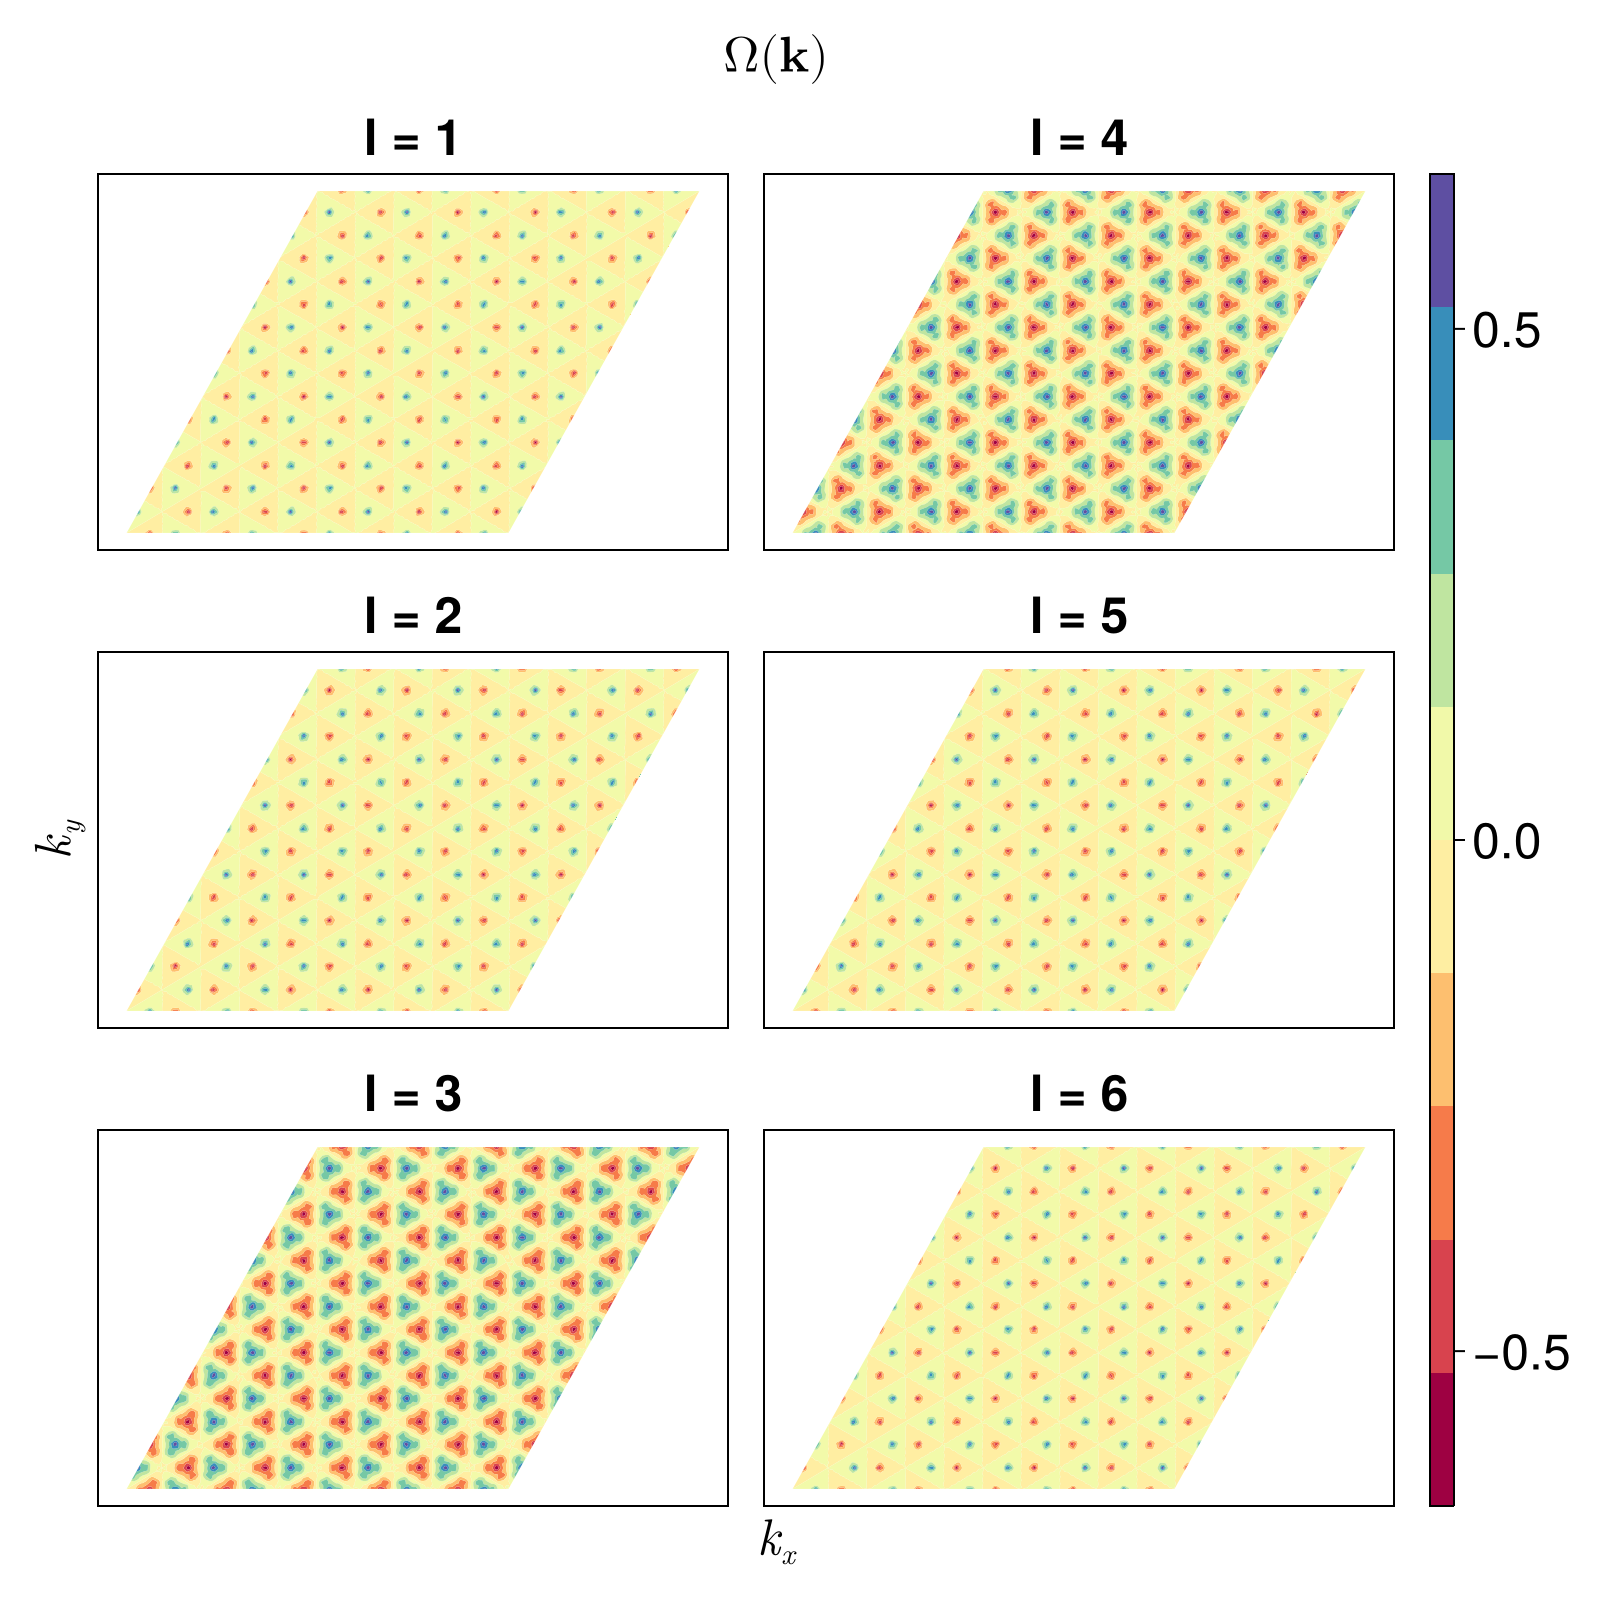

In [27]:
@time begin
berry_fig = Figure(size=(800, 800), fontsize=25)
plot_berry(berry_fig, kx_avg_list, ky_avg_list, flux_list)
end

<font size="12">Berry Curvature @ K</font>

In [28]:
# Fix Nl = 3
Nl = 3
# fix other sample parameters
uD = 100
pd = 100
rad = 0.1

0.1

In [29]:
# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, n, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, n, n, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, n)
    for i in 1:n
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, n, ky_pts[i])
    end
    return grid
end

k_zone (generic function with 1 method)

In [30]:
# explore a small region around K point
Kpt_grid = k_zone(K, pd, rad)

100×100×2 Array{Float64, 3}:
[:, :, 1] =
 4.13879  4.13879  4.13879  4.13879  …  4.13879  4.13879  4.13879  4.13879
 4.1398   4.1398   4.1398   4.1398      4.1398   4.1398   4.1398   4.1398
 4.14081  4.14081  4.14081  4.14081     4.14081  4.14081  4.14081  4.14081
 4.14182  4.14182  4.14182  4.14182     4.14182  4.14182  4.14182  4.14182
 4.14283  4.14283  4.14283  4.14283     4.14283  4.14283  4.14283  4.14283
 4.14384  4.14384  4.14384  4.14384  …  4.14384  4.14384  4.14384  4.14384
 4.14485  4.14485  4.14485  4.14485     4.14485  4.14485  4.14485  4.14485
 4.14586  4.14586  4.14586  4.14586     4.14586  4.14586  4.14586  4.14586
 4.14687  4.14687  4.14687  4.14687     4.14687  4.14687  4.14687  4.14687
 4.14788  4.14788  4.14788  4.14788     4.14788  4.14788  4.14788  4.14788
 4.14889  4.14889  4.14889  4.14889  …  4.14889  4.14889  4.14889  4.14889
 4.1499   4.1499   4.1499   4.1499      4.1499   4.1499   4.1499   4.1499
 4.15091  4.15091  4.15091  4.15091     4.15091  4.15091  4.1

In [31]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
for l in 1:2*Nl
    temp_flux, akx, aky = berry_curvature(l, Kpt_grid, pd, a, uD, t0, t1, t2, t3, t4, Nl)
    flux_list[l, :] = temp_flux
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
end
end

  4.216663 seconds (18.82 M allocations: 8.104 GiB, 16.40% gc time)


  4.109772 seconds (9.44 M allocations: 393.398 MiB, 1.69% gc time, 0.59% compilation time)


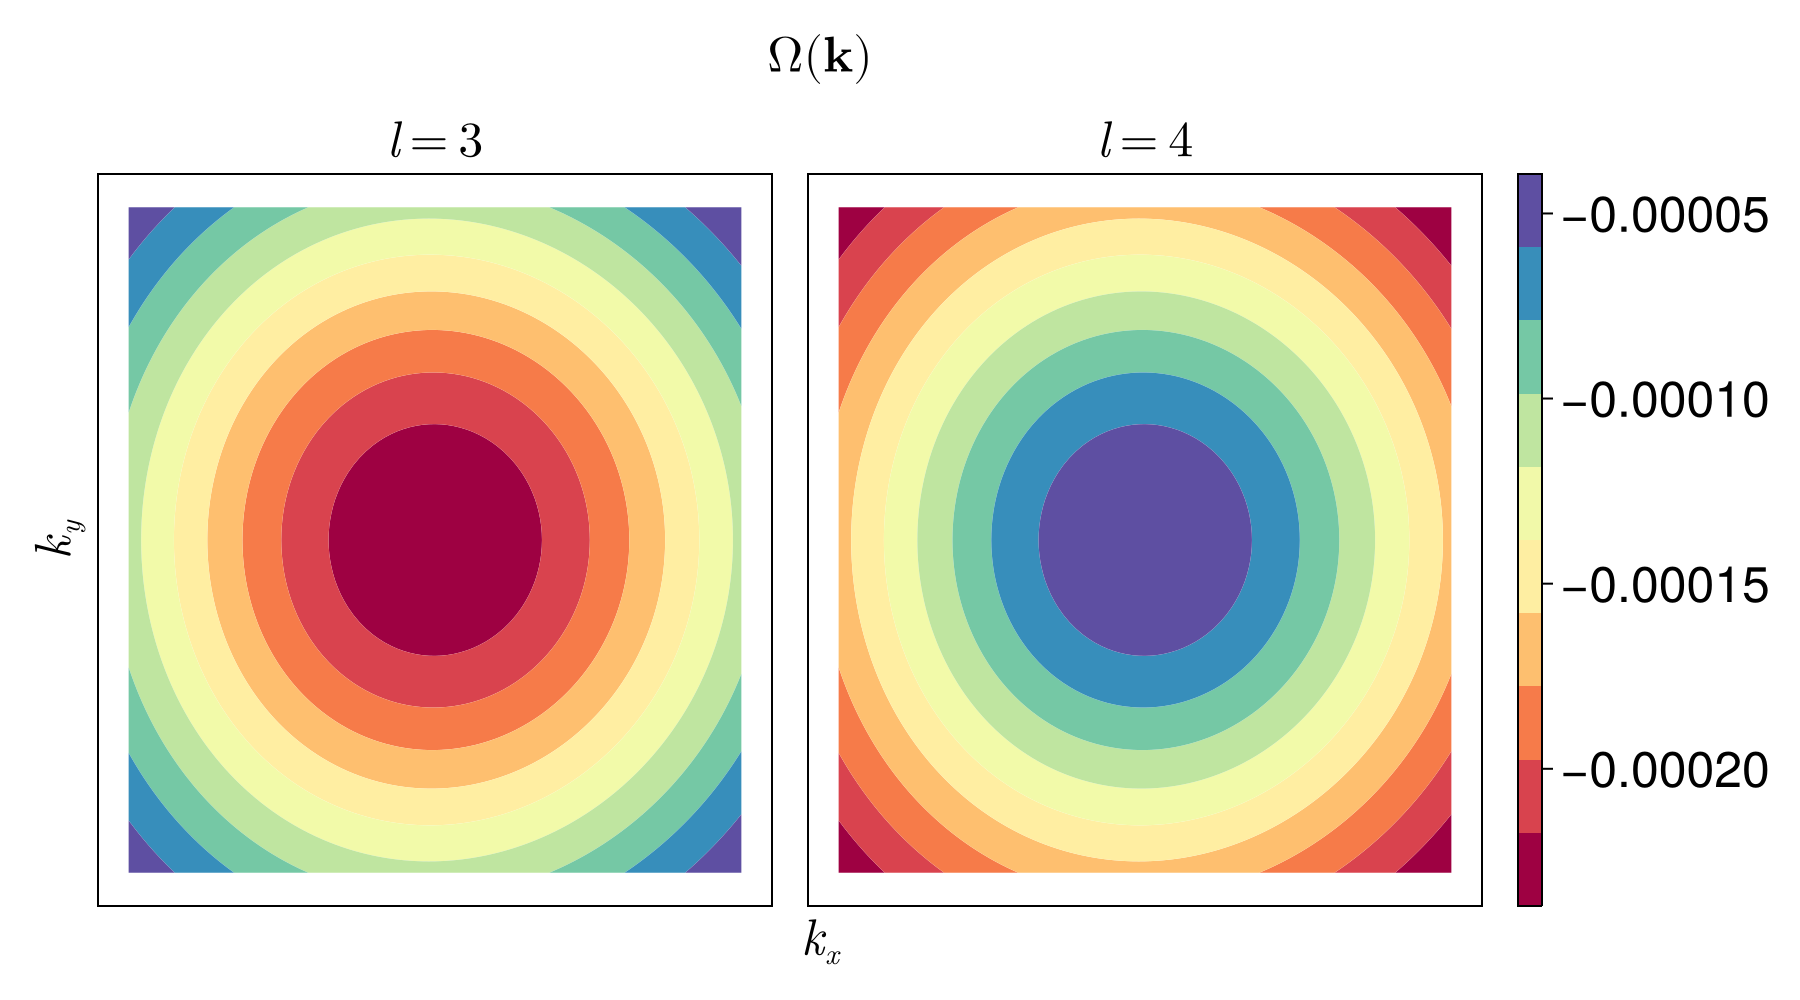

In [32]:
# plot Berry curvature just for l = 3,4 bands
@time begin
fig = Figure(size=(900, 500), fontsize=25)
    
t_string = L"l = 3"
ax = Axis(fig[1, 1], title = t_string)
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[3, :], ky_avg_list[3, :], flux_list[3, :], colormap = :Spectral)

t_string = L"l = 4"
ax = Axis(fig[1, 2], title = t_string)
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[4, :], ky_avg_list[4, :], flux_list[4, :], colormap = :Spectral)

X, ax, tr = tricontourf(kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)
cb = Colorbar(fig[1, 3], tr)
ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
hidedecorations!(ax, label = false)
hidespines!(ax)
fig
    
end

Around the k-point, this is what $\Omega (k)$ looks like. Then what we are going to do is calculate the Berry curvature in a small region aroung the $K$ point for varying $u_D$. Then we fix $k_y = 0$ and consider only a line $\Omega (k_x, k_y = 0)$. We will plot this quantity for several values of $u_D$.

In [33]:
# study for varying values of uD
uD_samps = 20
uD_list = range(-50, 50, uD_samps)

-50.0:5.2631578947368425:50.0

In [34]:
uD_flux_list = Array{Float64}(undef, uD_samps, 2, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, uD_samps, 2, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, uD_samps, 2, (pd - 1)^2)
for s in 1:uD_samps
    @time begin
    temp_flux, akx, aky = berry_curvature(3, Kpt_grid, pd, a, uD_list[s], t0, t1, t2, t3, t4, Nl)
    uD_flux_list[s, 1, :] = temp_flux
    kx_avg_list[s, 1, :] = akx
    ky_avg_list[s, 1, :] = aky
    temp_flux, akx, aky = berry_curvature(4, Kpt_grid, pd, a, uD_list[s], t0, t1, t2, t3, t4, Nl)
    uD_flux_list[s, 2, :] = temp_flux
    kx_avg_list[s, 2, :] = akx
    ky_avg_list[s, 2, :] = aky
    end
end

  1.504289 seconds (6.34 M allocations: 2.705 GiB, 13.35% gc time, 3.95% compilation time)
  1.378696 seconds (6.27 M allocations: 2.701 GiB, 12.37% gc time)
  1.400426 seconds (6.27 M allocations: 2.701 GiB, 12.38% gc time)
  1.405156 seconds (6.27 M allocations: 2.701 GiB, 13.54% gc time)
  1.406146 seconds (6.27 M allocations: 2.701 GiB, 12.41% gc time)
  1.421579 seconds (6.27 M allocations: 2.701 GiB, 12.19% gc time)
  1.450100 seconds (6.27 M allocations: 2.701 GiB, 12.24% gc time)
  1.409255 seconds (6.27 M allocations: 2.701 GiB, 12.38% gc time)
  1.467025 seconds (6.27 M allocations: 2.701 GiB, 12.05% gc time)
  1.382313 seconds (6.27 M allocations: 2.701 GiB, 11.69% gc time)
  1.403544 seconds (6.27 M allocations: 2.701 GiB, 13.21% gc time)
  1.422108 seconds (6.27 M allocations: 2.701 GiB, 13.01% gc time)
  1.432345 seconds (6.27 M allocations: 2.701 GiB, 13.16% gc time)
  1.393784 seconds (6.27 M allocations: 2.701 GiB, 13.15% gc time)
  1.376999 seconds (6.27 M allocations

In [35]:
# keep only the line ky = 0
filtered_uD_fluxes = Array{Float64}(undef, uD_samps, 2, pd - 1)
filtered_akx = Array{Float64}(undef, uD_samps, 2, pd - 1)
for s in 1:uD_samps
    index = 1
    for i in 1:(pd - 1)^2
        if ky_avg_list[s, 1, i] == 0
            filtered_uD_fluxes[s, 1, index] = uD_flux_list[s, 1, i]
            filtered_uD_fluxes[s, 2, index] = uD_flux_list[s, 2, i]
            filtered_akx[s, 1, index] = kx_avg_list[s, 1, i]
            filtered_akx[s, 2, index] = kx_avg_list[s, 2, i]
            index += 1
        end
    end
end

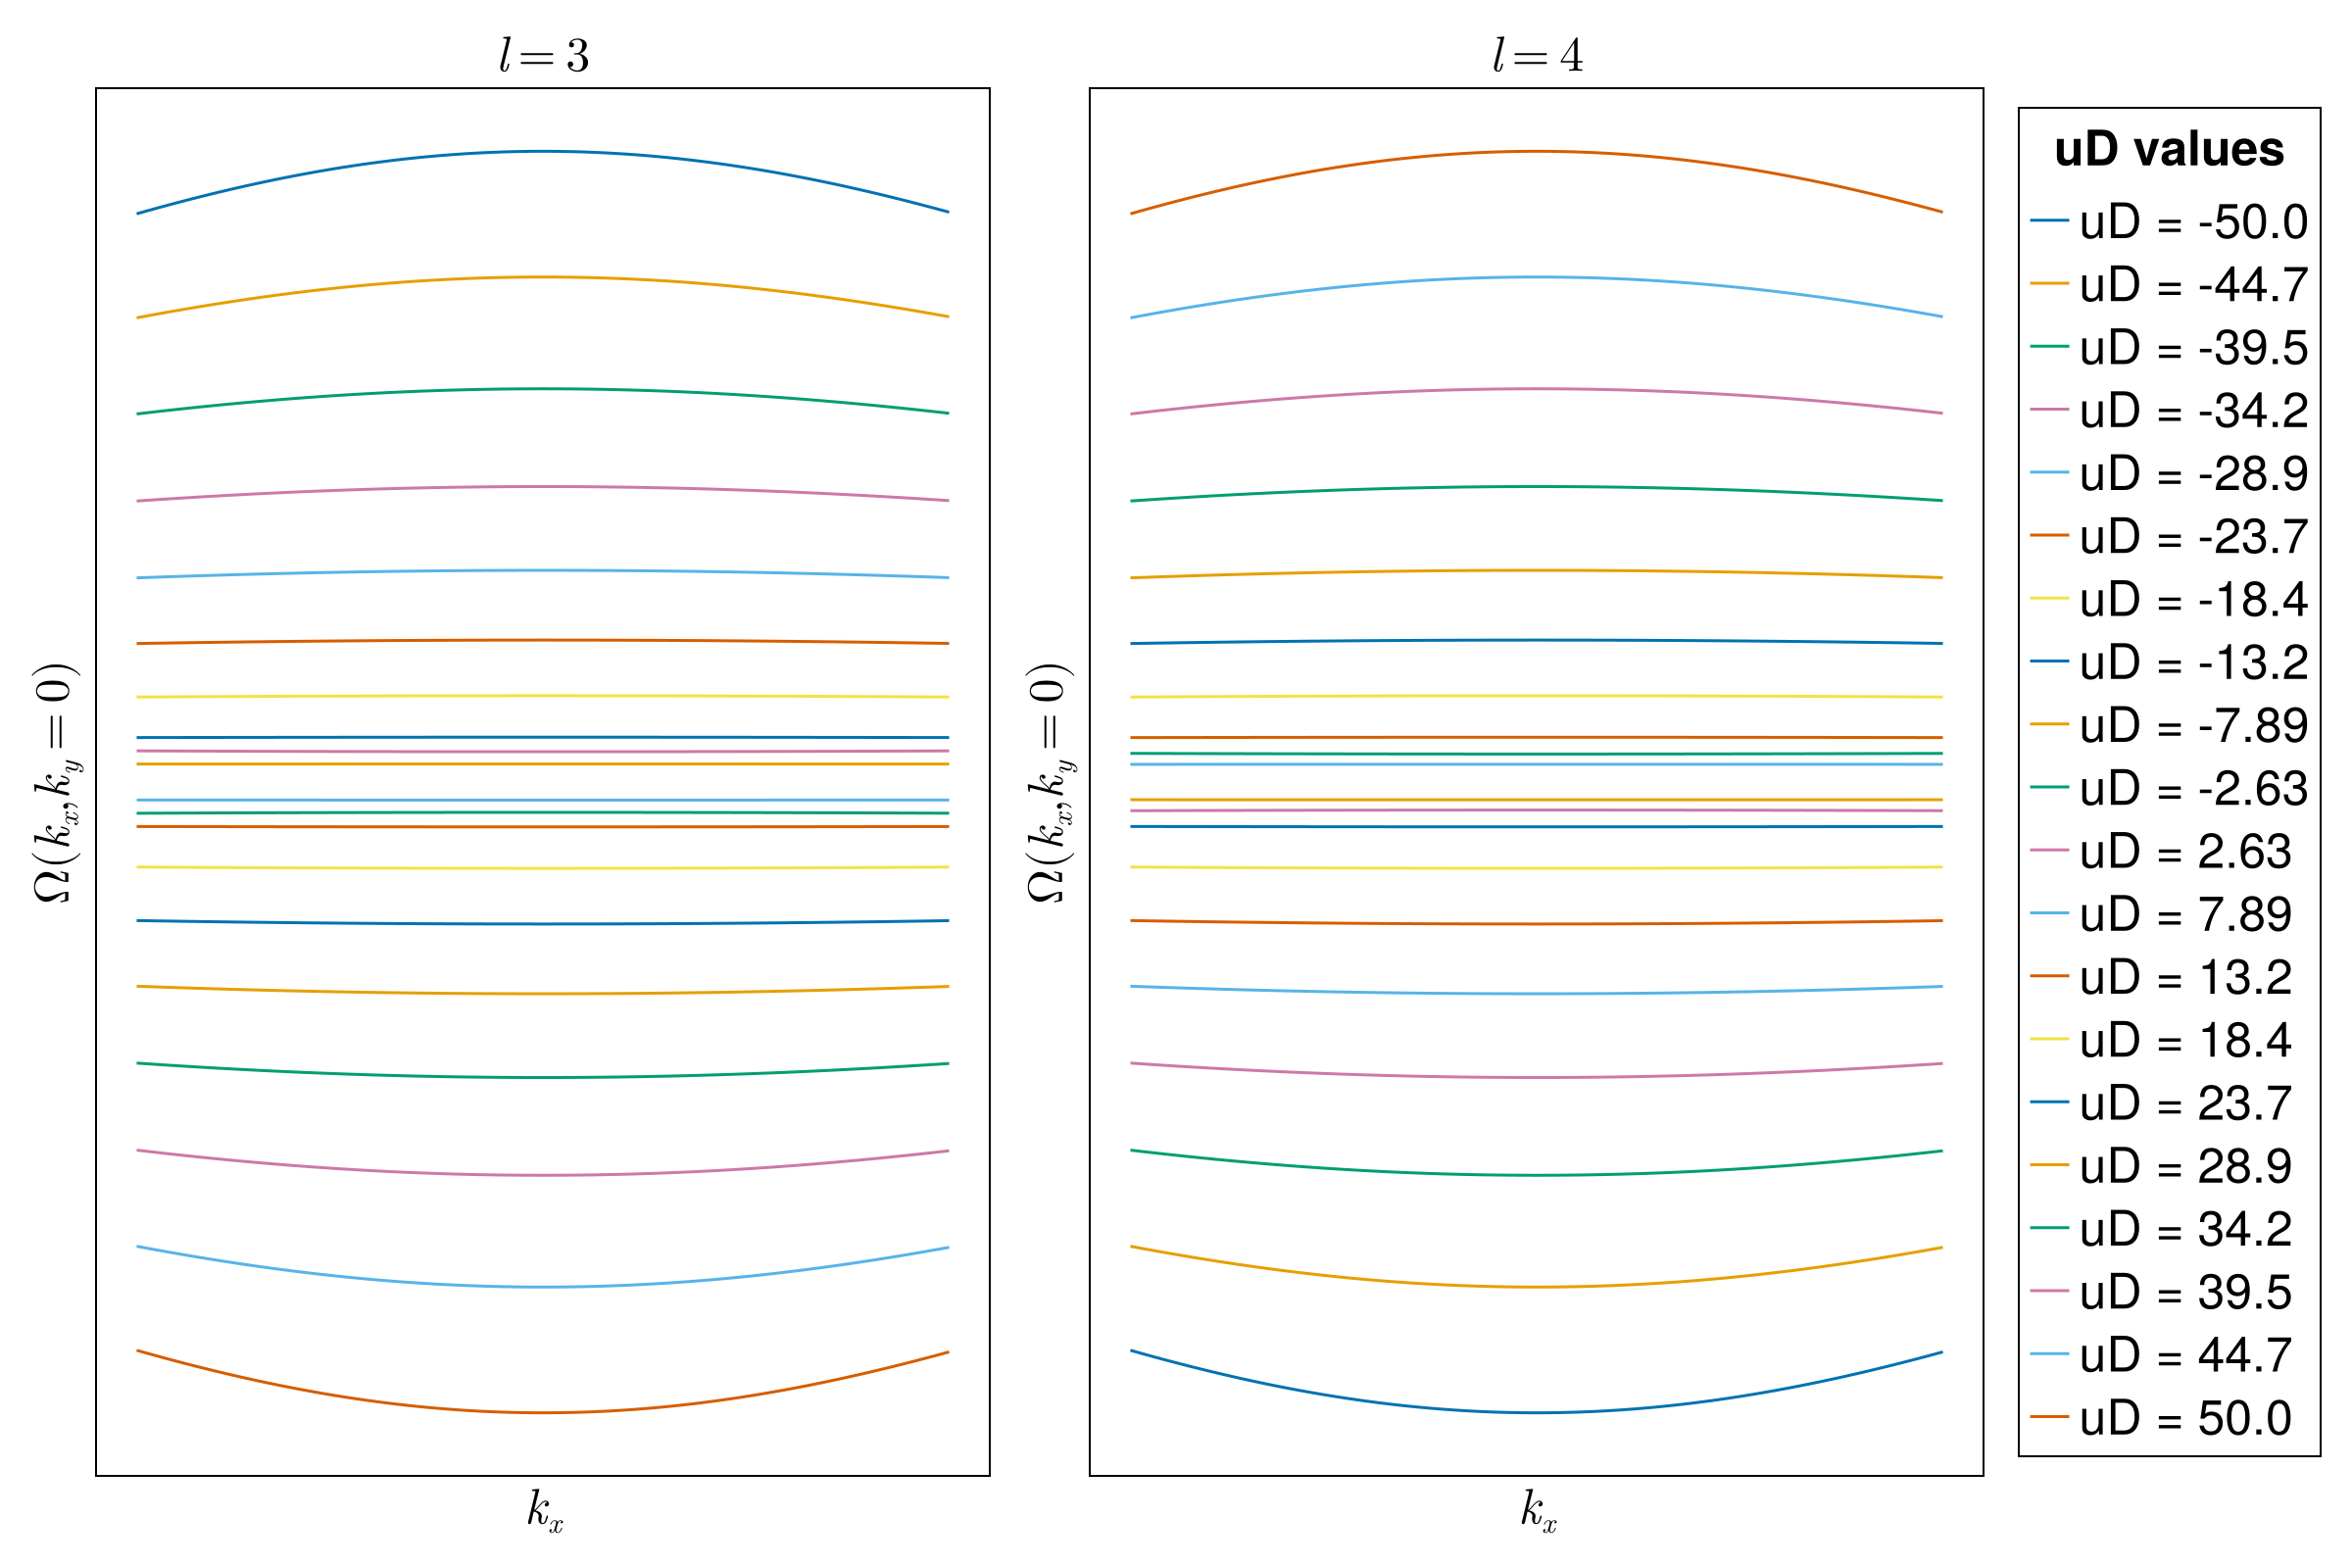

In [36]:
# Plot the l = 3, l = 4 berry curvatures for several values of uD across the line ky = 0
uD_fig = Figure(size=(1200, 800), fontsize=25)
ax3 = Axis(uD_fig[1, 1], title = L"l = 3", xlabel = L"k_x", ylabel = L"\Omega (k_x, k_y = 0)")
ax4 = Axis(uD_fig[1, 2], title = L"l = 4", xlabel = L"k_x", ylabel = L"\Omega (k_x, k_y = 0)")

for j in 1:uD_samps
    uD_val = round(uD_list[j], sigdigits = 3)
    lines!(ax3, filtered_akx[j, 1, :], filtered_uD_fluxes[j, 1, :], label = "uD = "*string(uD_val))
    lines!(ax4, filtered_akx[j, 2, :], filtered_uD_fluxes[j, 2, :], label = "uD = "*string(uD_val))
    hidedecorations!(ax3, label = false)
    hidedecorations!(ax4, label = false)
end
uD_fig[1, 3] = Legend(uD_fig, ax3, "uD values", framevisible = true)
uD_fig

Note the seemingly oscillatory behavior of $\Omega (k_x, k_y = 0)$. We can see this behavior because we have zoomed out sufficiently from the $K$-point. Additionally, observe that $l = 3$ and $l = 4$ appear to have "inverse" Berry curvatures.

In [37]:
# # create plot
# P = Figure(size=(900, 500), fontsize=20)
# # create and configure axes
# ax_k3 = Axis(P[1, 1], title = L"l = 3", xlabel = L"u_D", ylabel = L"\Omega (K)")
# hidedecorations!(ax_k3, label = false, ticklabels = false)
# ax_k4 = Axis(P[1, 2], title = L"l = 4", xlabel = L"u_D", ylabel = L"\Omega (K)")
# hidedecorations!(ax_k4, label = false, ticklabels = false)
# ax_major = Axis(P[:, :], title = "Berry Curvature vs D-field", titlegap = 70)
# hidedecorations!(ax_major, label = false)
# hidespines!(ax_major)

# # plot bands
# lines!(ax_k3, uD_list, uD_flux_list[:, 1])
# lines!(ax_k4, uD_list, uD_flux_list[:, 2])
# P

<font size="12">R5G</font>

In [38]:
# pd is point-density
pd = 100
delta = 150
v = 9
t = 3
hbar = 0.6582
L = 5

5

In [39]:
# square in k_space centered around the origin
function k_square(limit, n)
    vals = range(-limit/2, limit/2, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(limit, n, limit/2, vals[i])
    end
    return grid
end

k_square (generic function with 1 method)

In [55]:
k_grid = k_square(2*pi, pd)

100×100×2 Array{Float64, 3}:
[:, :, 1] =
 -3.14159  -3.14159  -3.14159  -3.14159  …  -3.14159  -3.14159  -3.14159
 -3.07813  -3.07813  -3.07813  -3.07813     -3.07813  -3.07813  -3.07813
 -3.01466  -3.01466  -3.01466  -3.01466     -3.01466  -3.01466  -3.01466
 -2.95119  -2.95119  -2.95119  -2.95119     -2.95119  -2.95119  -2.95119
 -2.88773  -2.88773  -2.88773  -2.88773     -2.88773  -2.88773  -2.88773
 -2.82426  -2.82426  -2.82426  -2.82426  …  -2.82426  -2.82426  -2.82426
 -2.76079  -2.76079  -2.76079  -2.76079     -2.76079  -2.76079  -2.76079
 -2.69733  -2.69733  -2.69733  -2.69733     -2.69733  -2.69733  -2.69733
 -2.63386  -2.63386  -2.63386  -2.63386     -2.63386  -2.63386  -2.63386
 -2.57039  -2.57039  -2.57039  -2.57039     -2.57039  -2.57039  -2.57039
 -2.50693  -2.50693  -2.50693  -2.50693  …  -2.50693  -2.50693  -2.50693
 -2.44346  -2.44346  -2.44346  -2.44346     -2.44346  -2.44346  -2.44346
 -2.37999  -2.37999  -2.37999  -2.37999     -2.37999  -2.37999  -2.37999
  ⋮       

In [56]:
function hRLG(delta, t, v, L, k)
    kx = k[1]
    ky = k[2]
    ham = zeros(ComplexF64, 2, 2)
    ham[1, 1] = delta
    ham[2, 2] = -delta
    ham[1, 2] = -t * (hbar * v / t)^L * (kx - 1im * ky)^L
    ham[2, 1] = -t * (hbar * v / t)^L * (kx + 1im * ky)^L
    return ham
end

hRLG (generic function with 1 method)

In [57]:
# Get the dipersions for fixed ky
K_temp_vals = Array{Float64}(undef, samps, samps, 2)
K_temp_points = Array{Float64}(undef, samps, samps, 2)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hRLG(delta, t, v, L, [kx, ky])
        vals = eigvals(Hermitian(ham))
        K_temp_vals[i, j, :] = real(vals)
        K_temp_points[i, j, :] = [kx, ky]
    end
end

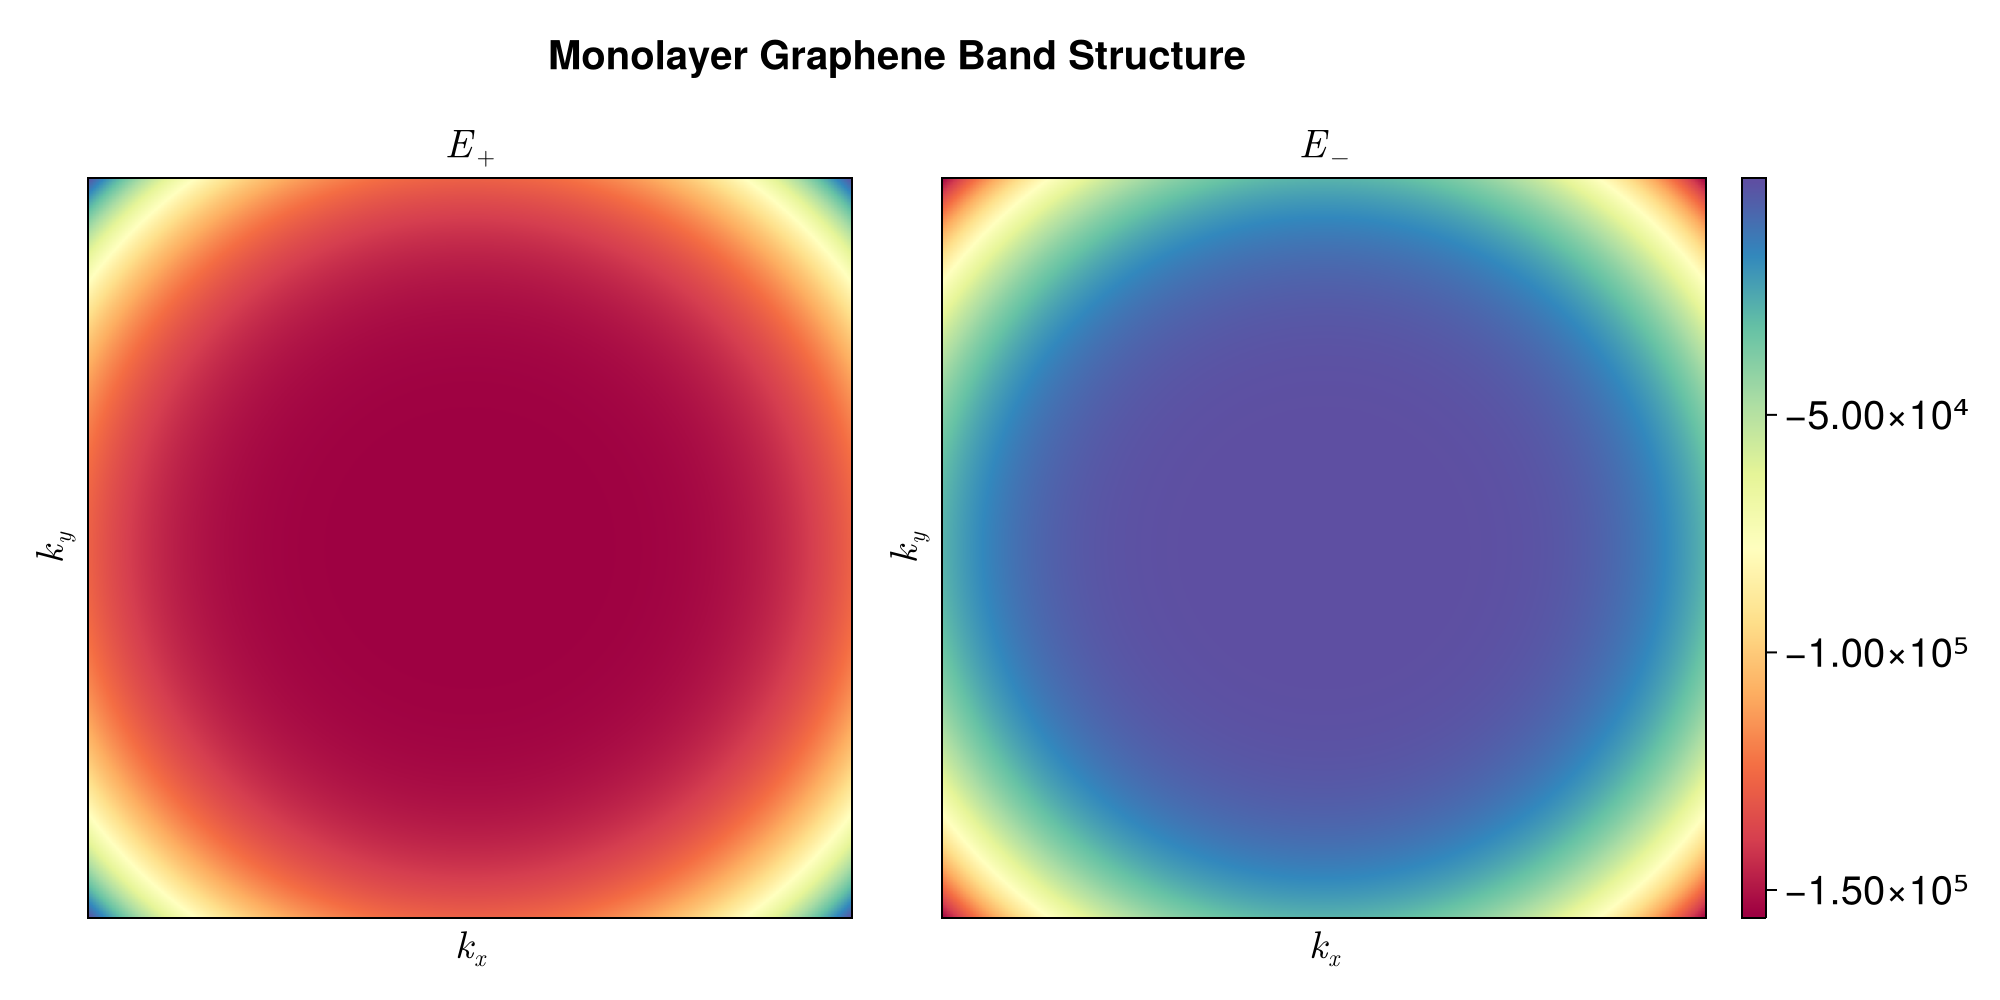

In [58]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)

# create and configure axes
ax_plus = Axis(P[1, 1], title = L"E_+", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_plus, label = false)
ax_minus = Axis(P[1, 2], title = L"E_-", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_minus, label = false)
ax_major = Axis(P[:, :], title = "Monolayer Graphene Band Structure", titlegap = 50)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

#plot dispersions
heatmap!(ax_plus, k_range, k_range, K_temp_vals[:, :, 2], colormap = :Spectral)
heatmap!(ax_minus, k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)
X, ax, tr = heatmap(k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)

#create and configure the colorbar
cb = Colorbar(P[1, 3], tr)
P

In [59]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec_R5G(kx, ky, delta, t, v, L, sign)
    ham = hRLG(delta, t, v, L, [kx, ky])
    vecs = eigvecs(Hermitian(ham))
    if sign > 0
        return vecs[:, 1]
    else
        return vecs[:, 2]
    end
end

eigen_vec_R5G (generic function with 1 method)

In [60]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta_R5G(x1, y1, x2, y2, delta, t, v, L, sign)
    ev1 = eigen_vec_R5G(x1, y1, delta, t, v, L, sign)
    ev2 = eigen_vec_R5G(x2, y2, delta, t, v, L, sign)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta_R5G (generic function with 1 method)

In [61]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux_R5G(x1, y1, x2, y2, x3, y3, x4, y4, delta, t, v, L, sign)
    big_theta = theta_R5G(x2, y2, x1, y1, delta, t, v, L, sign) * theta_R5G(x3, y3, x2, y2, delta, t, v, L, sign) * 
    theta_R5G(x4, y4, x3, y3, delta, t, v, L, sign) * theta_R5G(x1, y1, x4, y4, delta, t, v, L, sign)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux_R5G (generic function with 1 method)

In [62]:
# Berry curvature over all plaquettes
function berry_curvature_R5G(points, n, delta, t, v, L, sign)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            
            curvature = flux_R5G(x1, y1, x2, y2, x3, y3, x4, y4, delta, t, v, L, sign)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature_R5G (generic function with 1 method)

In [63]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2, (pd - 1)^2)
uc_flux_list = Array{Float64}(undef, 2, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2, (pd - 1)^2)
for l in 1:2
    temp_flux, akx, aky = berry_curvature_R5G(k_grid, pd, delta, t, v, L, 1.5 - l)
    uc_temp_flux, trash, trash = berry_curvature_R5G(uc_k_grid, pd, delta, t, v, L, 1.5 - l)
    uc_flux_list[l, :] = uc_temp_flux
    flux_list[l, :] = temp_flux
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
    end
end

  0.540774 seconds (8.51 M allocations: 926.267 MiB, 13.66% gc time, 6.32% compilation time)


In [64]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2)
for l in 1:2
    chern_numbers[l] = sum(uc_flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

chern_numbers = [-0.833325987548051, 0.8333259875480507]


2-element Vector{Float64}:
 -0.833325987548051
  0.8333259875480507

  4.126219 seconds (11.00 M allocations: 436.614 MiB, 1.81% gc time, 0.00% compilation time)


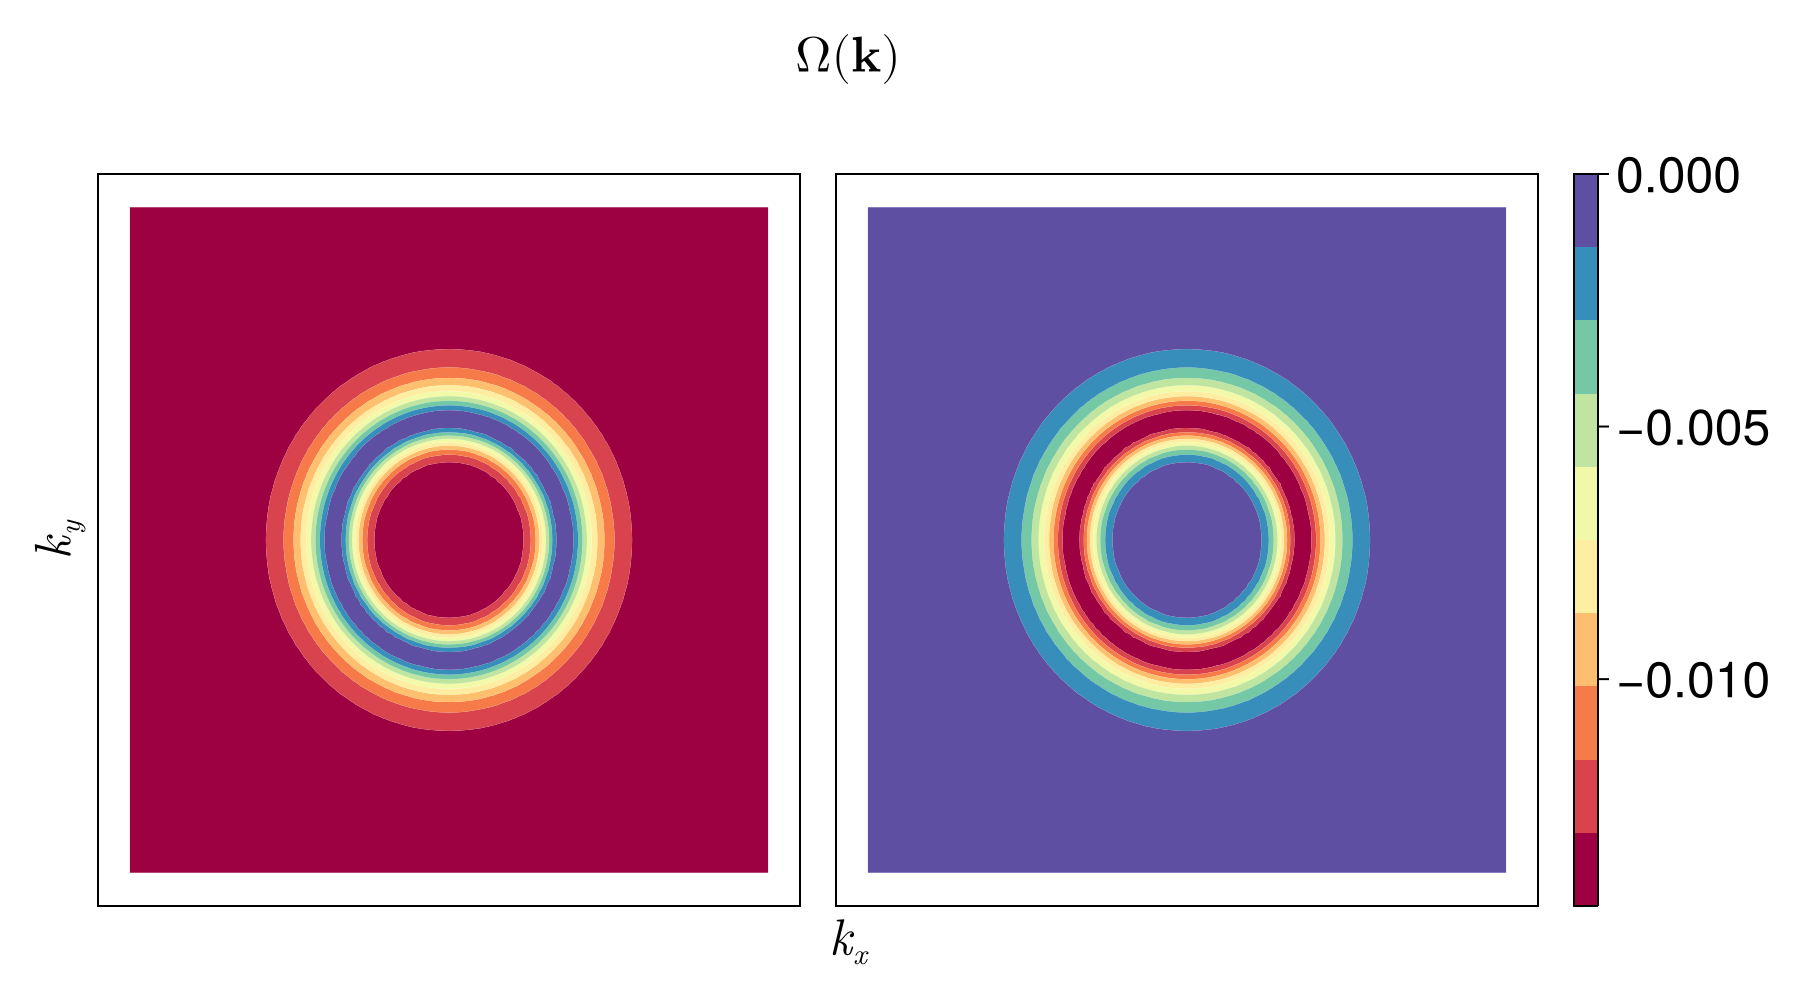

In [65]:
@time begin
fig = Figure(size=(900, 500), fontsize=25)
    
ax = Axis(fig[1, 1])
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[2, :], ky_avg_list[2, :], flux_list[2, :], colormap = :Spectral)

ax = Axis(fig[1, 2])
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)

X, ax, tr = tricontourf(kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)
cb = Colorbar(fig[1, 3], tr)
ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
hidedecorations!(ax, label = false)
hidespines!(ax)
fig
end

<font size="12">2D Dirac Fermions</font>

In [66]:
function hDirac(m, k)
    kx = k[1]
    ky = k[2]
    ham = zeros(ComplexF64, 2, 2)
    ham[1, 1] = 2 - m - cos(kx) - cos(ky)
    ham[2, 2] = -(2 - m - cos(kx) - cos(ky))
    ham[1, 2] = -1im * sin(ky) + sin(kx)
    ham[2, 1] = 1im * sin(ky) + sin(kx)
    return ham
end

hDirac (generic function with 1 method)

In [180]:
samps = 1000
k_range = range(-pi, pi, samps)
m = 0.01

0.01

In [181]:
# Get the dipersions for fixed ky
K_temp_vals = Array{Float64}(undef, samps, samps, 2)
K_temp_points = Array{Float64}(undef, samps, samps, 2)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hDirac(m, [kx, ky])
        vals = eigvals(Hermitian(ham))
        K_temp_vals[i, j, :] = real(vals)
        K_temp_points[i, j, :] = [kx, ky]
    end
end

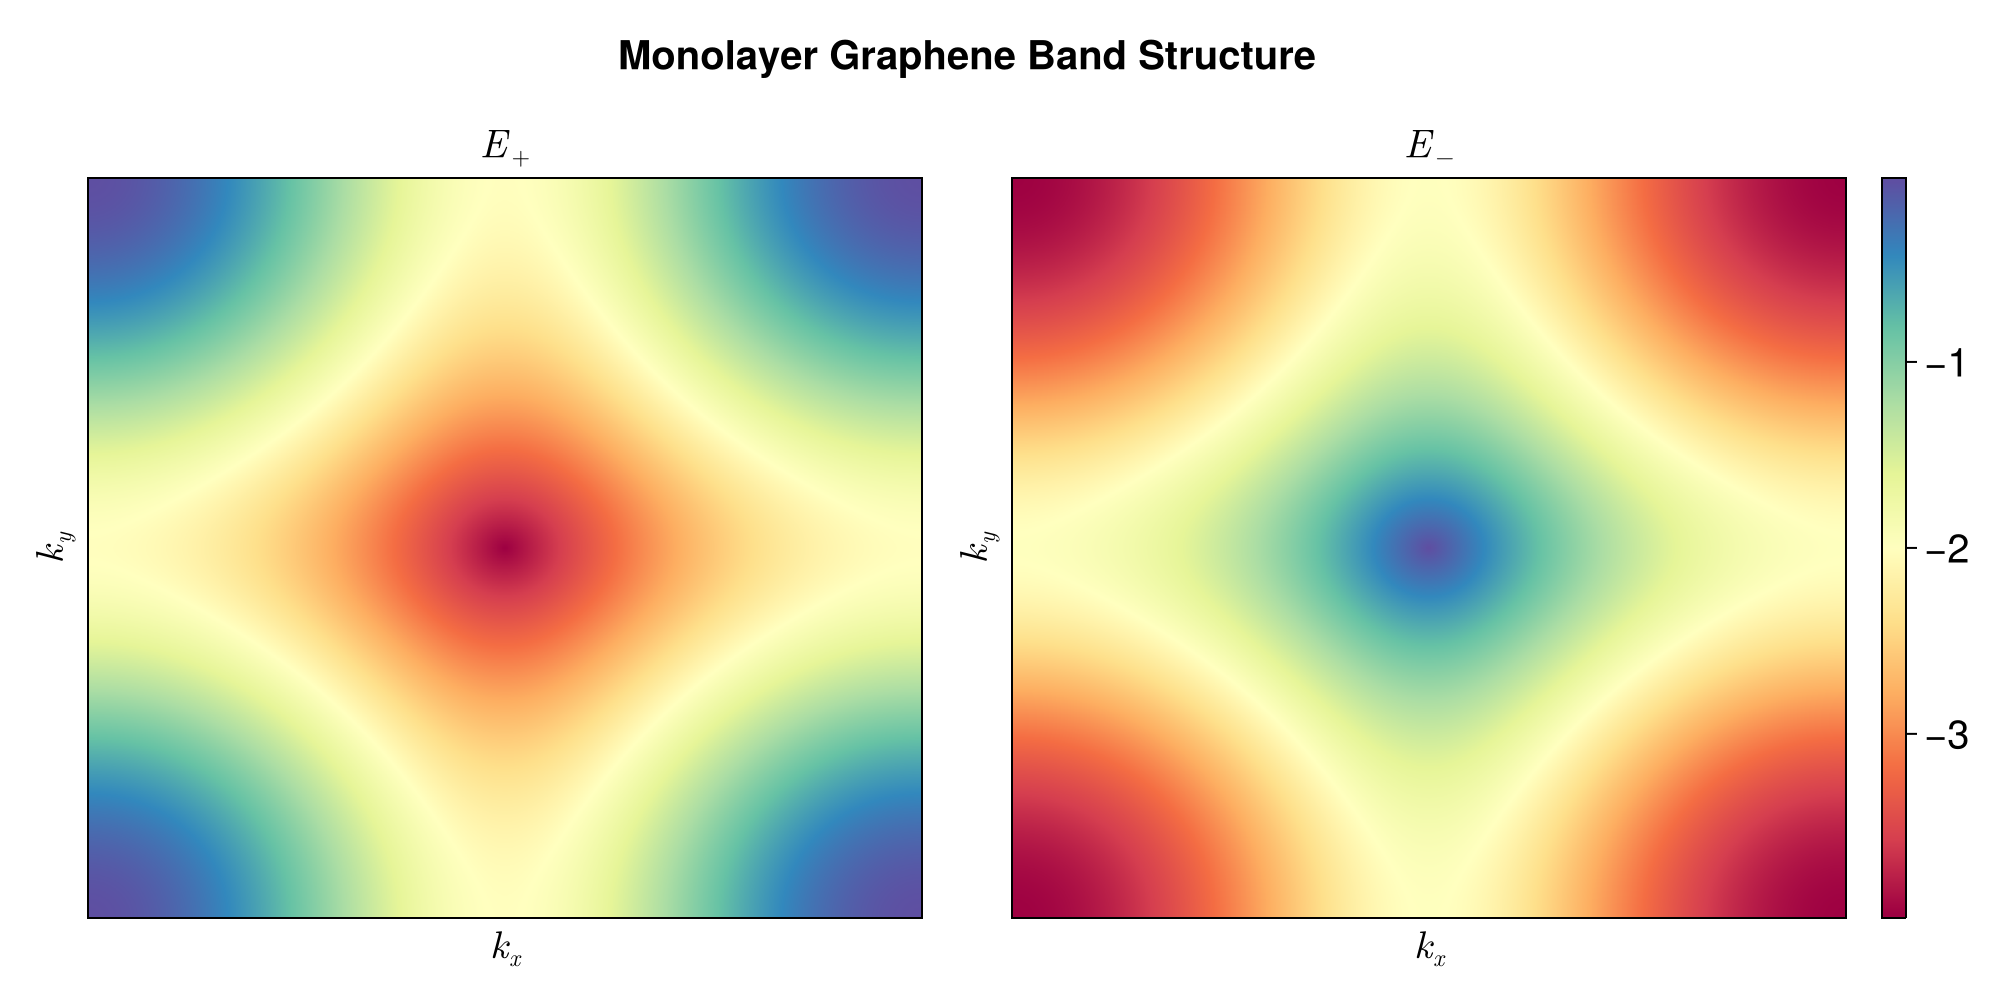

In [182]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)

# create and configure axes
ax_plus = Axis(P[1, 1], title = L"E_+", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_plus, label = false)
ax_minus = Axis(P[1, 2], title = L"E_-", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_minus, label = false)
ax_major = Axis(P[:, :], title = "Monolayer Graphene Band Structure", titlegap = 50)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

#plot dispersions
heatmap!(ax_plus, k_range, k_range, K_temp_vals[:, :, 2], colormap = :Spectral)
heatmap!(ax_minus, k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)
X, ax, tr = heatmap(k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)

#create and configure the colorbar
cb = Colorbar(P[1, 3], tr)
P

In [191]:
uc_k_grid = k_square(2 * pi, pd)

100×100×2 Array{Float64, 3}:
[:, :, 1] =
 -3.14159  -3.14159  -3.14159  -3.14159  …  -3.14159  -3.14159  -3.14159
 -3.07813  -3.07813  -3.07813  -3.07813     -3.07813  -3.07813  -3.07813
 -3.01466  -3.01466  -3.01466  -3.01466     -3.01466  -3.01466  -3.01466
 -2.95119  -2.95119  -2.95119  -2.95119     -2.95119  -2.95119  -2.95119
 -2.88773  -2.88773  -2.88773  -2.88773     -2.88773  -2.88773  -2.88773
 -2.82426  -2.82426  -2.82426  -2.82426  …  -2.82426  -2.82426  -2.82426
 -2.76079  -2.76079  -2.76079  -2.76079     -2.76079  -2.76079  -2.76079
 -2.69733  -2.69733  -2.69733  -2.69733     -2.69733  -2.69733  -2.69733
 -2.63386  -2.63386  -2.63386  -2.63386     -2.63386  -2.63386  -2.63386
 -2.57039  -2.57039  -2.57039  -2.57039     -2.57039  -2.57039  -2.57039
 -2.50693  -2.50693  -2.50693  -2.50693  …  -2.50693  -2.50693  -2.50693
 -2.44346  -2.44346  -2.44346  -2.44346     -2.44346  -2.44346  -2.44346
 -2.37999  -2.37999  -2.37999  -2.37999     -2.37999  -2.37999  -2.37999
  ⋮       

In [192]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec_Dirac(kx, ky, m, sign)
    ham = hDirac(m, [kx, ky])
    vecs = eigvecs(Hermitian(ham))
    if sign > 0
        return vecs[:, 1]
    else
        return vecs[:, 2]
    end
end

eigen_vec_Dirac (generic function with 1 method)

In [193]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta_Dirac(x1, y1, x2, y2, m, sign)
    ev1 = eigen_vec_Dirac(x1, y1, m, sign)
    ev2 = eigen_vec_Dirac(x2, y2, m, sign)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta_Dirac (generic function with 1 method)

In [194]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux_Dirac(x1, y1, x2, y2, x3, y3, x4, y4, m, sign)
    big_theta = theta_Dirac(x2, y2, x1, y1, m, sign) * theta_Dirac(x3, y3, x2, y2, m, sign) * 
    theta_Dirac(x4, y4, x3, y3, m, sign) * theta_Dirac(x1, y1, x4, y4, m, sign)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux_Dirac (generic function with 2 methods)

In [195]:
# Berry curvature over all plaquettes
function berry_curvature_Dirac(points, n, m, sign)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            
            curvature = flux_Dirac(x1, y1, x2, y2, x3, y3, x4, y4, m, sign)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature_Dirac (generic function with 1 method)

In [196]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2, (pd - 1)^2)
uc_flux_list = Array{Float64}(undef, 2, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2, (pd - 1)^2)
for l in 1:2
    temp_flux, akx, aky = berry_curvature_Dirac(uc_k_grid, pd, m, 1.5 - l)
    uc_temp_flux, trash, trash = berry_curvature_Dirac(uc_k_grid, pd, m, 1.5 - l)
    uc_flux_list[l, :] = uc_temp_flux
    flux_list[l, :] = temp_flux
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
    end
end

  0.407201 seconds (4.75 M allocations: 849.677 MiB, 9.71% compilation time)


In [197]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2)
for l in 1:2
    chern_numbers[l] = sum(uc_flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

chern_numbers = [0.9999999999999999, -1.0000000000000002]


2-element Vector{Float64}:
  0.9999999999999999
 -1.0000000000000002

  4.194479 seconds (10.88 M allocations: 427.727 MiB, 3.70% gc time, 0.00% compilation time)


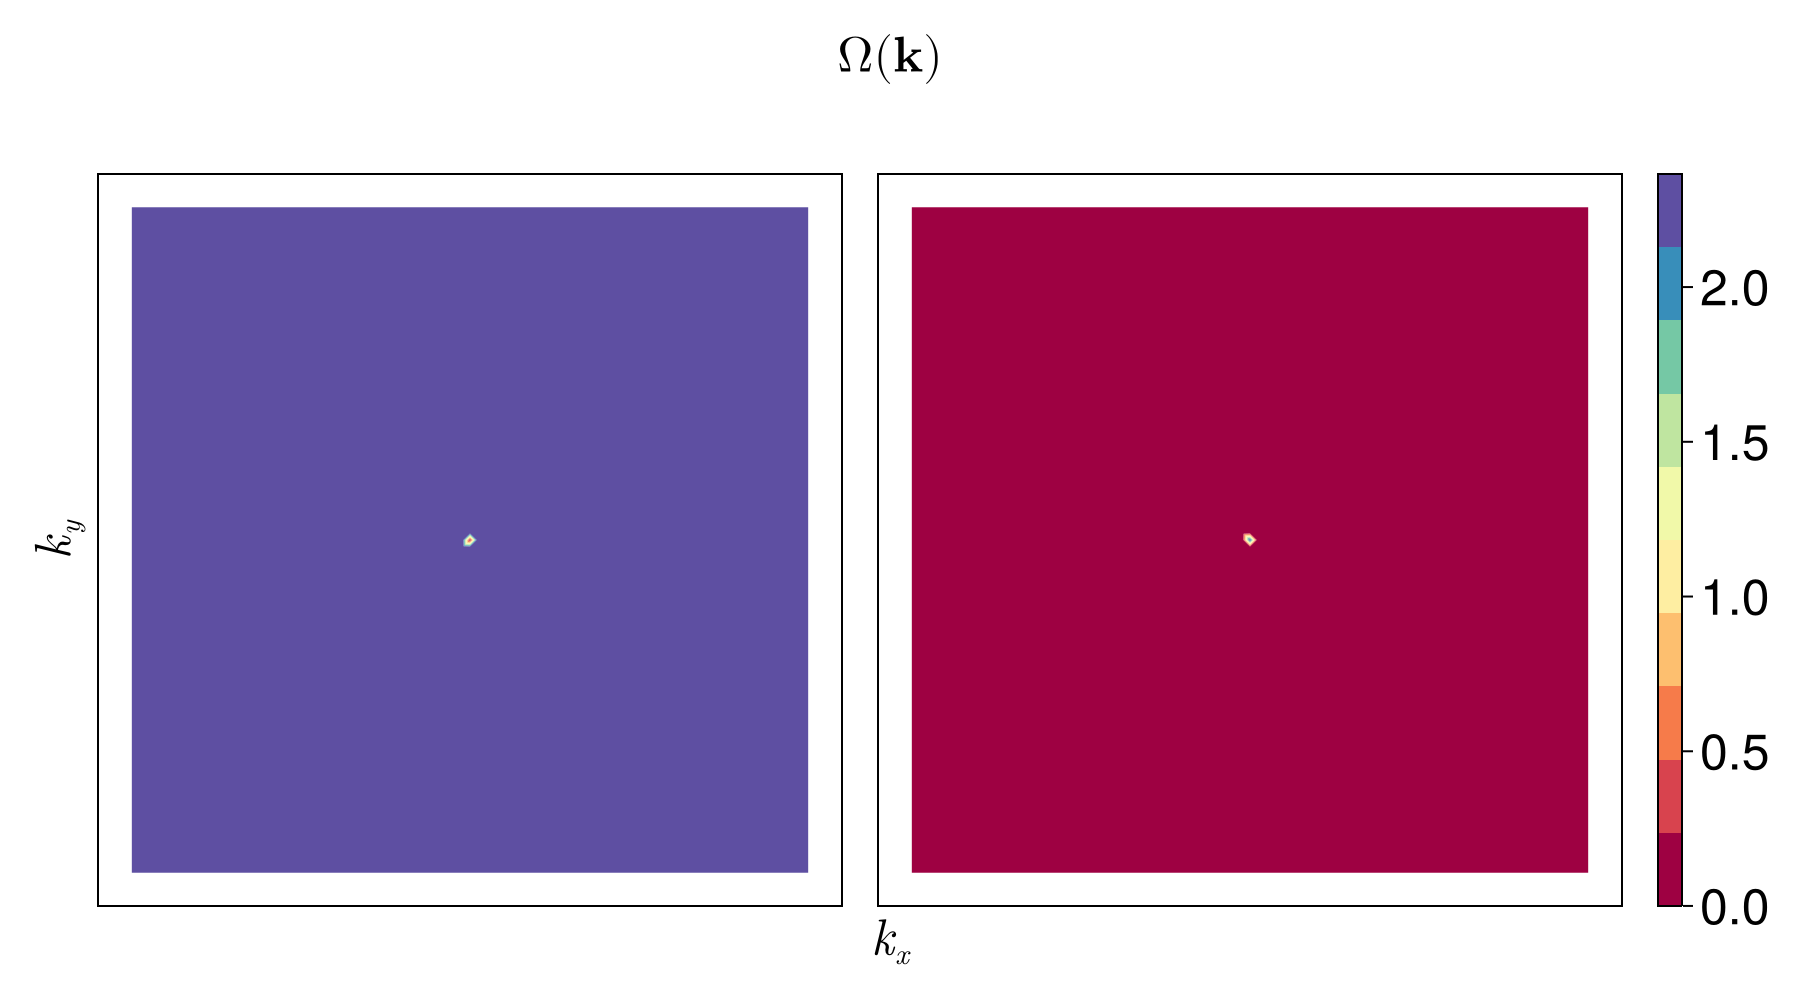

In [198]:
@time begin
fig = Figure(size=(900, 500), fontsize=25)
    
ax = Axis(fig[1, 1])
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[2, :], ky_avg_list[2, :], flux_list[2, :], colormap = :Spectral)

ax = Axis(fig[1, 2])
hidedecorations!(ax)
tricontourf!(ax, kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)

X, ax, tr = tricontourf(kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)
cb = Colorbar(fig[1, 3], tr)
ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
hidedecorations!(ax, label = false)
hidespines!(ax)
fig
end